<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#выводи" data-toc-modified-id="выводи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>выводи</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#model-LogisticRegression" data-toc-modified-id="model-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>model LogisticRegression</a></span></li><li><span><a href="#Model-DecisionTreeClassifier" data-toc-modified-id="Model-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model DecisionTreeClassifier</a></span></li><li><span><a href="#Model-LGBMClassifier" data-toc-modified-id="Model-LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model LGBMClassifier</a></span></li><li><span><a href="#тест" data-toc-modified-id="тест-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>тест</a></span></li><li><span><a href="#Model-bert" data-toc-modified-id="Model-bert-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Model bert</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import re


import torch
import transformers
from tqdm import notebook

import spacy

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')


import warnings

from lightgbm import LGBMClassifier


import sklearn 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')



from tqdm.notebook import tqdm




[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
try:
    comtext = pd.read_csv('/datasets/toxic_comments.csv')
except:
    comtext  = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
comtext.info()
comtext = comtext.drop(['Unnamed: 0'], axis=1)#удалим лишние признаки
#df_tweets=comtext.copy()# копируем ВСЕ данные для BERT
df_tweets = comtext.sample(400).reset_index(drop=True)#режем данные по возможностям компа для модели BERT
comtext.head()
comtext.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


0

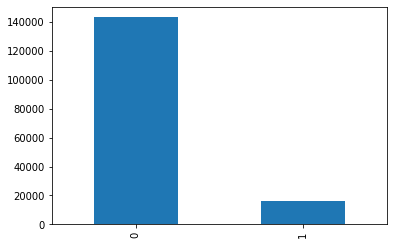

In [4]:
comtext['toxic'].value_counts().plot.bar();

In [5]:
def clean_data(t):
    t = re.sub(r"(?:\n|\r)", " ", t)
    t = re.sub(r"[^a-zA-Z ]+", "", t).strip()
    t = t.lower()
    return t

comtext['text'] = comtext['text'].apply(clean_data)
comtext.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [6]:
train, test = train_test_split(comtext, test_size = 0.2, random_state = 12345)
test, valid = train_test_split(test, test_size=0.5,  random_state = 12345)
print(train.shape, valid.shape, test.shape)

features_train = train.drop('toxic', axis=1)
target_train = train['toxic'].values

features_valid = valid.drop('toxic', axis=1)
target_valid = valid['toxic'].values

features_test = test.drop('toxic', axis=1)
target_test = test['toxic']

(127433, 2) (15930, 2) (15929, 2)


In [7]:
#lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [8]:

# def lemon(tex):
#     tokens=nltk.word_tokenize(tex)
#     tokens=[lemmatizer.lemmatize(t) for t in tokens]
#     tokens=" ".join(tokens)
#     return tokens



# print(train['text'][0])
# train_c = train['text'].apply(lemon) 
# valid_c = valid['text'].apply(lemon) 
# test_c = test['text'].apply(lemon) 
# print(train_c[0])

In [20]:
sentence = "The striped bats are hanging on their feet for best"
doc1 = nlp(sentence)
" ".join([token.lemma_ for token in doc1])

'the stripe bat be hang on their foot for good'

In [14]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


print(train['text'][0])
train_c = train['text'].apply(lemmatize) 
valid_c = valid['text'].apply(lemmatize) 
test_c = test['text'].apply(lemmatize) 
print(train_c[0])

# Он выполнил все лемматизации, которые так же выполнил лемматизатор Wordnet,
# с проставленным правильным тегом POS.
# Плюс к этому также лемматизируется такое слово как «best» превращаясь в «good».


explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now
explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I m retire now


In [ ]:
#  def lemmatize(text):
#     lem=[]
#     for to in text:
#         tokens=nltk.word_tokenize(to)
#         tokens=[lemmatizer.lemmatize(t) for t in tokens]
#         tokens=" ".join(tokens)
#         lem.append(tokens)
#     return lem
# train_c =lemmatize(train_c)
# valid_c = lemmatize(valid_c)
# test_c = lemmatize(test_c)


In [15]:

stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,1))

tf_idf_train = count_tf_idf.fit_transform(train_c)

tf_idf_valid = count_tf_idf.transform(valid_c)

tf_idf_test = count_tf_idf.transform(test_c)


### выводи

прочитали данные 
пропусков и дупликатов нет
удалили лишние признаки столбец 'Unnamed: 0' что бы индекси не дублировать
сделали лемматизациюб удалили лишние и привели к нижнему регистру символи функцией clean_data
Создали корпус из лематизированных и очищеных тексов
Классы несбалансированы учтем  при обучении моделей
Разделили датасет на выборки:

## Обучение

### model LogisticRegression

(0.7654567461171033, {'C': 9, 'penalty': 'l2'}) 10min

In [16]:
%%time
param1={'C' :[1,10,5,9],
        'penalty' : ['l2','l1']   
}
model_lin= LogisticRegression( class_weight = 'balanced',solver="liblinear")#.fit(tf_idf_train, target_train)
gml=GridSearchCV(model_lin,param1,scoring='f1').fit(tf_idf_train, target_train)
gml.best_score_,gml.best_params_

# f1_lin=f1_score(target_valid, (model_lin.predict(tf_idf_valid)))
# f1_lin

CPU times: user 6min 46s, sys: 4min 12s, total: 10min 59s
Wall time: 10min 59s


(0.7654567461171033, {'C': 9, 'penalty': 'l2'})

### Model DecisionTreeClassifier

(0.6479637927996934, {'criterion': 'entropy', 'max_depth': 300}) 21 min

In [17]:
%%time
param2={'max_depth':[10,50,100,150,300,250,200],
        "criterion":["entropy"]}#"gini",
model_dtc = DecisionTreeClassifier(class_weight = 'balanced')#.fit(tf_idf_train, target_train)
gmd=GridSearchCV(model_dtc,param2,scoring='f1').fit(tf_idf_train, target_train)
gmd.best_score_,gmd.best_params_


# f1_dtc=f1_score(target_valid, (model_dtc.predict(tf_idf_valid)))
# f1_dtc


CPU times: user 21min 45s, sys: 5.45 s, total: 21min 50s
Wall time: 21min 51s


(0.6681651634462142, {'criterion': 'entropy', 'max_depth': 200})

###  Model LGBMClassifier

(0.7556789789978563, {'learning_rate': 0.5, 'max_depth': 16} 28 min

In [18]:
%%time
param3={"max_depth":[10,16],
        "learning_rate":[0.3,0.5,1]}   

lm = LGBMClassifier(n_estimators=100)#.fit(tf_idf_train, target_train)
glm=GridSearchCV(lm,param3,scoring='f1').fit(tf_idf_train, target_train)
glm.best_score_,glm.best_params_



# f1_lm=f1_score(target_valid, (lm.predict(tf_idf_valid)))
# f1_lm


CPU times: user 25min 28s, sys: 1.72 s, total: 25min 30s
Wall time: 25min 35s


(0.759785383575356, {'learning_rate': 0.3, 'max_depth': 16})

LogisticRegression дает лучшие резултаты f1== 0.76 (0.759785383575356, {'learning_rate': 0.3, 'max_depth': 16}) если сбалансировать и чуть чуть подобрать параметры
Пороговое значение метрики 0.75 преодолено, получено 0.78. Лучшая модель - логистическая регрессия с подробранными гиперпараметрами.
так же Model LGBMClassifier преодолел 75 порог а вот Model DecisionTreeClassifier f1 == 66 не преодолел порог 

### тест

In [19]:
f1_best=f1_score(target_test, (gml.predict(tf_idf_test)))
f1_best

0.7713055954088951

###  Model bert

In [21]:
df_tweets.head()

,text,toxic
0,Stan Kemp \n\nIt's also the site's biggest sho...,0
1,"Don't\nGet to big for your own shoes Lassy ], ...",0
2,", and has been blocked indefinitely.\n Please ...",0
3,"Edit request \n\nThank you for , can you do th...",0
4,"All right, (sorry to interrupt) I think we sho...",0


In [32]:
#tokenizer = transformers.BertTokenizer(vocab_file='/datasets/ds_bert/vocab.txt')#unitary/toxic-bert
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

In [33]:
tokenized = df_tweets['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=512 ))

In [34]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [35]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [36]:
attention_mask = np.where(padded != 0, 1, 0)

In [37]:
#config = transformers.BertConfig.from_json_file('/datasets/ds_bert/bert_config.json')#
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')

In [38]:
#я не смого в калабе скачать этот и еше 2 файла.txt и json
#model = transformers.BertModel.from_pretrained('unitary/toxic-bert', config=config)#unitary/toxic-bert  #/datasets/ds_bert/rubert_model.bin
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')  

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
batch_size = 10
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())




  0%|          | 0/40 [00:00<?, ?it/s]

In [40]:
features2 = np.concatenate(embeddings)
target2 = df_tweets['toxic']

In [41]:
train_features2, test_features2, train_target2, test_target2 = train_test_split(features2, target2, test_size=0.2)

m_bert.get_params().keys()

In [42]:
m_bert= LogisticRegression()
param4={"C" :[1,5,9,11,15,20],
        "penalty":['l2',"l1"] ,
        "class_weight" : ['balanced'],
        "solver":["liblinear"],
        "n_jobs": [-1]
}
ggb=GridSearchCV(m_bert,param4,scoring='f1').fit(train_features2, train_target2)
print("f1 и лучшие параметры",ggb.best_score_,ggb.best_params_)



f1 и лучшие параметры 0.951048951048951 {'C': 5, 'class_weight': 'balanced', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}
f1 на тестовой выборке 1.0


## Выводы

model bert дал шикарные резултаты f1== 0.95 на 400 строк отрезкею мы использовали модель, которая видет токсичные тексты 'unitary/toxic-bert'